# 1. Skip-gram with naiive softmax 

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture2.pdf
* https://arxiv.org/abs/1301.3781
* http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
from IPython.display import Image, display

In [2]:
print(torch.__version__)
print(nltk.__version__)

0.2.0+751198f
3.2.4


In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if w in word2index.keys() else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word,word2index):
    return Variable(LongTensor([word2index[word]]) if word in word2index.keys() else LongTensor([word2index["<UNK>"]]))

## Data load and Preprocessing 

### Load corpus : Gutenberg corpus

If you don't have gutenberg corpus, you can download it first using nltk.download()

In [6]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [7]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:100] # sampling sentences for test
corpus = [[word.lower() for word in sent] for sent in corpus]

### Extract Stopwords from unigram distribution's tails

In [8]:
word_count = Counter(flatten(corpus))
border =int(len(word_count)*0.01) 

In [9]:
stopwords = word_count.most_common()[:border]+list(reversed(word_count.most_common()))[:border]

In [10]:
stopwords = [s[0] for s in stopwords]

In [11]:
stopwords

[',', '.', 'the', 'of', 'and', 'baleine', '--(', 'fat', 'oil', 'boiling']

### Build vocab

In [12]:
vocab = list(set(flatten(corpus))-set(stopwords))
vocab.append('<UNK>')

In [13]:
print(len(set(flatten(corpus))),len(vocab))

592 583


In [14]:
word2index = {'<UNK>' : 0} # for masking

for vo in vocab:
    if vo not in word2index.keys():
        word2index[vo]=len(word2index)

index2word = {v:k for k,v in word2index.items()} 

### Prepare train data 

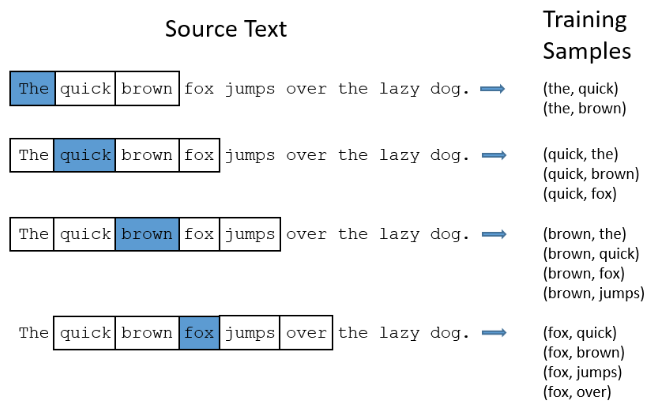

In [2]:
Image('../images/01.skipgram-prepare-data.png') # borrowed image from http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

In [15]:
WINDOW_SIZE = 3
windows =  flatten([list(nltk.ngrams(['<DUMMY>']*WINDOW_SIZE+c+['<DUMMY>']*WINDOW_SIZE,WINDOW_SIZE*2+1)) for c in corpus])

In [16]:
windows[0]

('<DUMMY>', '<DUMMY>', '<DUMMY>', '[', 'moby', 'dick', 'by')

In [17]:
train_data = []

for window in windows:
    for i in range(WINDOW_SIZE*2+1):
        if i==WINDOW_SIZE or window[i]=='<DUMMY>': continue
        train_data.append((window[WINDOW_SIZE],window[i]))

print(train_data[:WINDOW_SIZE*2])

[('[', 'moby'), ('[', 'dick'), ('[', 'by'), ('moby', '['), ('moby', 'dick'), ('moby', 'by')]


In [18]:
X_p=[]
y_p=[]

In [19]:
train_data[0]

('[', 'moby')

In [20]:
for tr in train_data:
    X_p.append(prepare_word(tr[0],word2index).view(1,-1))
    y_p.append(prepare_word(tr[1],word2index).view(1,-1))

In [21]:
train_data = list(zip(X_p,y_p))

In [22]:
len(train_data)

7606

## Modeling

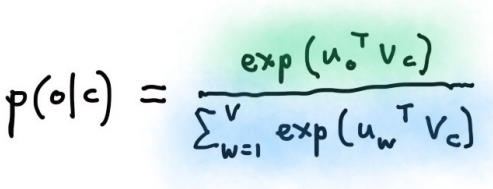

In [3]:
Image('../images/01.skipgram-objective.png') # borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture2.pdf

In [59]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size,projection_dim):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim)
        self.embedding_u = nn.Embedding(vocab_size, projection_dim)

        self.embedding_v.weight.data.uniform_(-1, 1) # init
        self.embedding_u.weight.data.uniform_(0, 0) # init
        #self.out = nn.Linear(projection_dim,vocab_size)
    def forward(self, center_words,target_words, outer_words):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        outer_embeds = self.embedding_u(outer_words) # B x V x D
        
        scores = target_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2) # Bx1xD * BxDx1 => Bx1
        norm_scores = outer_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2) # BxVxD * BxDx1 => BxV
        
        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores),1).unsqueeze(1))) # log-softmax
        
        return nll # negative log likelihood
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds 

## Train  

In [60]:
EMBEDDING_SIZE = 30
BATCH_SIZE = 256
EPOCH = 100

In [61]:
losses = []
model = Skipgram(len(word2index),EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [62]:
for epoch in range(EPOCH):
    for i,batch in enumerate(getBatch(BATCH_SIZE,train_data)):
        
        inputs, targets = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        vocabs = prepare_sequence(list(vocab),word2index).expand(inputs.size(0),len(vocab))  # B x V
        model.zero_grad()

        loss = model(inputs,targets,vocabs)
        
        loss.backward()
        optimizer.step()
   
        losses.append(loss.data.tolist()[0])

    if epoch % 10==0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch,np.mean(losses)))
        losses=[]

Epoch : 0, mean_loss : 6.20
Epoch : 10, mean_loss : 4.38
Epoch : 20, mean_loss : 3.48
Epoch : 30, mean_loss : 3.31
Epoch : 40, mean_loss : 3.26
Epoch : 50, mean_loss : 3.24
Epoch : 60, mean_loss : 3.22
Epoch : 70, mean_loss : 3.22
Epoch : 80, mean_loss : 3.21
Epoch : 90, mean_loss : 3.20


## Test

In [63]:
def word_similarity(target,vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target,word2index))
    else:
        target_V = model.prediction(prepare_word(target,word2index))
    similarities=[]
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        cosine_sim = F.cosine_similarity(target_V,vector).data.tolist()[0] 
        similarities.append([vocab[i],cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10] # sort by similarity

In [64]:
test = random.choice(list(vocab))
test

'least'

In [65]:
word_similarity(test,vocab)

[['at', 0.8147411346435547],
 ['every', 0.7143548130989075],
 ['case', 0.6975079774856567],
 ['secure', 0.6121522188186646],
 ['heart', 0.5974172949790955],
 ['including', 0.5867112278938293],
 ['please', 0.5557640194892883],
 ['has', 0.5536234974861145],
 ['while', 0.5366998314857483],
 ['you', 0.509368896484375]]